In [1]:
from scipy import stats
import numpy as np
import CombinedFCToolBox as cfc  #import the combinedFC toolbox
import matplotlib.pyplot as plt

# Demo for some CombinedFC Toolbox functions

### For more information and details about the functions and methods implemented here refer to: Sanchez-Romero, R., Cole, M.W. (Preprint) "Combining multiple functional connectivity methods to improve causal inferences" bioRxiv. https://doi.org/10.1101/841890

### Simulate a directed network model: adjusted Erdos-Renyi or adjusted Static Power Law

directed network with 200 nodes and 920 edges


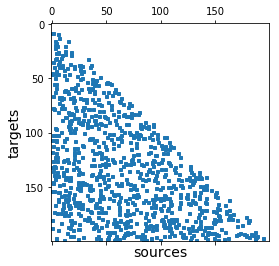

In [2]:
#the graphModel function requires installation: "conda install -c conda-forge python-igraph"
#or "pip install python-igraph"
#https://igraph.org/python/

model = 'ErdosRenyi'  #or StaticPowerLaw
edgedensity = 900 #aprox. number of edges
nNodes = 200 #number of nodes

#returns a binary directed network encoded as column(source) -> row(target)
#for example, the entry Cij, implies that j -> i (j is a directed cause of i)
C = cfc.graphModel(model,edgedensity*2,nNodes)

#Note: the user can define her own model as long as it is a binary
#directed matrix encoded as column(source) -> row(target).

#plot the network model
real_nEdges = np.sum(C==1) #get the real number of edges
print(f'directed network with {nNodes} nodes and {real_nEdges} edges')
plt.spy(C,markersize=3)
plt.xlabel('sources',fontsize=14)
plt.ylabel('targets',fontsize=14)
plt.show()

### Simulate data for the network, using the linear model X = WX + E, and pseudoempirical noise terms E

In [3]:
#use the network model defined above
network = C 
#Connectivity coefficients are sampled from a Uniform(min,max) distribution
min_coefficient = -1
max_coefficient = 1
number_datapoints = 1200

#returns a dataset X [datapoints x nodes] and a coefficient matrix W [nodes x nodes]
X, W = cfc.simulateData.pseudoEmpiricalData(network, 
                                            min_coeff = min_coefficient, 
                                            max_coeff = max_coefficient, 
                                            nDatapoints=number_datapoints
                                            )

### An alternative to the pseudoEmpirical noise terms is to sample E from a Standard Gaussian (or Beta)

In [4]:
#network model defined above
network = C 
#Connectivity coefficients are sampled from a Uniform(min,max) distribution
min_coefficient = -1
max_coefficient = 1
number_datapoints = 1200
type_distribution = 'Gaussian' #standard Gaussian(mean=0,std=1) or "nonGaussian" a Beta(1,5)

X, W = cfc.simulateData.syntheticData(network, 
                                      min_coeff = min_coefficient, 
                                      max_coeff = max_coefficient, 
                                      nDatapoints = number_datapoints,
                                      distribution = type_distribution
                                      )

### Apply combinedFC to the simulated data

In [5]:
#Important: the dataset input has to be a matrix [datapoints x nodes], and without header.
#see the function code for more details.

Mcfc = cfc.combinedFC(dataset = X,  
            methodCondAsso = 'partialCorrelation', #method used to compute conditional associations
            methodParcorr='inverseCovariance',     #if Partial Correlation, choose "inversecovariance" or "regression"
            alphaCondAsso = 0.01,                  #alpha cutoff for conditional association
            methodAsso = 'correlation',            #method used to compute bivariate associations
            alphaAsso = 0.01,                      #alpha curtoff for bivariate association
            equivalenceTestAsso = False,           #True for equivalence test, False for non-significance criterion
            lower_bound = -0.2,                    #lower bound for equivalence test
            upper_bound = +0.2                     #upper bound for equivalence test
            )

### Apply partial correlation to the simulated data

In [6]:
#returns the symmetric partial correlation connectivity matrix [nodes x nodes]
M_parcorr = cfc.partialCorrelationSig(dataset =X, 
                                      alpha = 0.01, 
                                      method = 'inverseCovariance'   #"inverseCovariance" or "regression"
                                      )

### Apply bivariate correlation to the simulated data

In [7]:
#returns the symmetric bivariate correlation connectivity matrix [nodes x nodes]
M_corr = cfc.correlationSig(dataset = X,
                            alpha=0.01  #alpha cutoff for the significance test: two-sided z-test
                            )   

### Accuracy of the methods in the simulation, using precision and recall
We want to quantify the accuracy of a method to recover the adjacencies of the true model.
<br>
precision = true positives / (true positives + false positives)
<br>
recall = true positives / (true positives + false negatives)

In [8]:
# the true model is the simulated network C
trueModel = C

#estimated models
estimatedModel = Mcfc
precision = cfc.precision(estimatedModel,trueModel)
recall = cfc.recall(estimatedModel,trueModel)
#print results
print(f'combinedFC accuracy:')
print(f'precision: {round(precision,3)}')  #round up result to 3 decimals
print(f'recall: {round(recall,3)}')
print(' ')


estimatedModel = M_parcorr
precision = cfc.precision(estimatedModel,trueModel)
recall = cfc.recall(estimatedModel,trueModel)
print(f'partial correlation accuracy:')
print(f'precision: {round(precision,3)}')
print(f'recall: {round(recall,3)}')
print(' ')

estimatedModel = M_corr
precision = cfc.precision(estimatedModel,trueModel)
recall = cfc.recall(estimatedModel,trueModel)
print(f'bivariate correlation accuracy:')
print(f'precision: {round(precision,3)}')
print(f'recall: {round(recall,3)}')

combinedFC accuracy:
precision: 0.61
recall: 0.762
 
partial correlation accuracy:
precision: 0.378
recall: 0.824
 
bivariate correlation accuracy:
precision: 0.093
recall: 0.884


## Alternative implementations of combinedFC

### Implement combinedFC with the regression approach for partial correlation and an equivalence test for zero correlations

In [9]:
Mcfc_eq = cfc.combinedFC(dataset = X,  
                methodCondAsso = 'partialCorrelation', #method used to compute conditional associations
                methodParcorr='regression',            #for Partial Correlation, "inversecovariance" or "regression"
                alphaCondAsso = 0.01,                  #alpha cutoff for conditional association
                methodAsso = 'correlation',            #method used to compute bivariate associations
                alphaAsso = 0.01,                      #alpha curtoff for bivariate association
                equivalenceTestAsso = True,            #True for equivalence test, False for non-significance criterion
                lower_bound = -0.2,                    #lower bound for equivalence test
                upper_bound = +0.2                     #upper bound for equivalence test
                )

### Accuracy of combinedFC with the regression approach for partial correlation and an equivalence test for zero correlations

In [10]:
trueModel = C
estimatedModel = Mcfc_eq
precision = cfc.precision(estimatedModel,trueModel)
recall = cfc.recall(estimatedModel,trueModel)
print(f'combinedFC with regression approach for partial correlation and an Equivalence test, accuracy:')
print(f'precision: {round(precision,3)}')
print(f'recall: {round(recall,3)}')

combinedFC with regression approach for partial correlation and an Equivalence test, accuracy:
precision: 0.71
recall: 0.694


### Implement combinedFC with simple regression and multiple regression

In [11]:
#returns the symmetric combinedFC connectivity matrix [nodes x nodes]
Mcfc_reg = cfc.combinedFC(dataset = X,  
                   methodCondAsso = 'multipleRegression', #use multiple regression for conditional associations  
                   alphaCondAsso = 0.01,                  #alpha cutoff for the multiple regression coefficients
                   methodAsso = 'simpleRegression',       #use simple regression for the bivariate associations        
                   alphaAsso = 0.01,                      #alpha cutoff for the simple regression coefficients 
                    )

### Accuracy of combinedFC with simple regression and multiple regression

In [12]:
trueModel = C
estimatedModel = Mcfc_reg
precision = cfc.precision(estimatedModel,trueModel)
recall = cfc.recall(estimatedModel,trueModel)
print(f'combinedFC with simple and multiple regression, accuracy:')
print(f'precision: {round(precision,3)}')
print(f'recall: {round(recall,3)}')

combinedFC with simple and multiple regression, accuracy:
precision: 0.61
recall: 0.762


## Simulate a high-dimensional dataset (nodes >> datapoints)

In [40]:
#define a sparser directed network
model = 'ErdosRenyi'  #or ErdosRenyi
edgedensity = 1000 #aprox. number of edges
nNodes = 800 #number of nodes
#call the function to generate the network
C = cfc.graphModel(model,edgedensity*2,nNodes)

real_nEdges = np.sum(C==1)
print(f'directed network with {nNodes} nodes and {real_nEdges} edges')

directed network with 800 nodes and 1023 edges


In [41]:
#generate the high-dimensional dataset using the above directed network
network = C #network model defined above
#Connectivity coefficients are sampled from a Uniform(min,max) distribution
min_coefficient = -1
max_coefficient = 1
#number of nodes of the network
nNodes = network.shape[1]
#define number of datapoints to be half of the number of nodes (nodes >> datapoints)
number_datapoints = np.round(nNodes/2).astype(int) #round and define as integer

#generate data using Gaussian noise terms E
type_distribution = 'Gaussian'  #standard Gaussian(mean = 0,std =1)
X_hd, W_hd = cfc.simulateData.syntheticData(network, 
                                            min_coeff = min_coefficient, 
                                            max_coeff = max_coefficient, 
                                            nDatapoints = number_datapoints,
                                            distribution = type_distribution
                                            )
print(f'X_hd dataset has {X_hd.shape[1]} nodes and {X_hd.shape[0]} datapoints')

X_hd dataset has 800 nodes and 400 datapoints


### Implement combinedFC with a high-dimensional method to compute partial correlations
The method used is glasso, a regularized solution to the inverse covariance approach for high-dimensional datasets.

In [ ]:
#the glasso implementation uses as default a cross-validation with 10 kfolds to choose the regularization parameter
Mcfc_hd = cfc.combinedFC(dataset = X_hd,  
                    methodCondAsso = 'partialCorrelation', #method for conditional associations
                    methodParcorr = 'glasso',              #use glasso as method for partial correlations
                    alphaCondAsso = 0.01,                  #alpha cutoff for the multiple regression coefficients
                    methodAsso = 'correlation',            #use simple regression for the bivariate associations        
                    alphaAsso = 0.01,                      #alpha cutoff for the simple regression coefficients
                    )

### Apply partial correlation using glasso to the high-dimensional dataset

In [ ]:
#the glasso implementation uses as default a cross-validation with 10 kfolds to choose the regularization parameter
Mparcorr_hd = cfc.partialCorrelationSig(dataset =X_hd, 
                                      alpha = 0.01, 
                                      method = 'glasso'   #use glasso for high-dimensional datasets
                                      )

### Apply correlation to the high-dimensional dataset

In [44]:
Mcorr_hd = cfc.correlationSig(dataset = X_hd,
                            alpha=0.01  #alpha cutoff for the significance test: two-sided z-test
                            )   

### Precision and recall of the methods for the high-dimensional problem

In [45]:
# the true model is the simulated network C
trueModel = C

estimatedModel = Mcfc_hd
precision = cfc.precision(estimatedModel,trueModel)
recall = cfc.recall(estimatedModel,trueModel)
print(f'combinedFC using glasso to compute partial correlations, accuracy:')
print(f'precision: {round(precision,3)}')
print(f'recall: {round(recall,3)}')
print(' ')

estimatedModel = Mparcorr_hd
precision = cfc.precision(estimatedModel,trueModel)
recall = cfc.recall(estimatedModel,trueModel)
print(f'partial correlation using glasso, accuracy:')
print(f'precision: {round(precision,3)}')
print(f'recall: {round(recall,3)}')
print(' ')

estimatedModel = Mcorr_hd
precision = cfc.precision(estimatedModel,trueModel)
recall = cfc.recall(estimatedModel,trueModel)
print(f'bivariate correlation accuracy:')
print(f'precision: {round(precision,3)}')
print(f'recall: {round(recall,3)}')

combinedFC using glasso to compute partial correlations, accuracy:
precision: 0.732
recall: 0.778
 
partial correlation using glasso, accuracy:
precision: 0.448
recall: 0.785
 
bivariate correlation accuracy:
precision: 0.165
recall: 0.881
